In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

JAVA_BASELINE_MS = 10.0
PYTHON_BASELINE_MS = 105.0
HARD_JAVA_BASE_MS = 35.0
HARD_PYTHON_BASE_MS = 330.0

EFFICIENCY_THRESHOLD_FACTOR = 1.2

FILE_NAMES = ['easy_splay_tree_benchmarking_results.csv', 
              'medium_splay_tree_benchmarking_results.csv', 
              'hard_splay_tree_benchmarking_results.csv']

all_data = []

for filename in FILE_NAMES:
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        all_data.append(df)
    else:
        print(f"Warning: File not found: {filename}. Skipping.")

if not all_data:
    raise FileNotFoundError("No results CSV files were loaded.")

df_combined = pd.concat(all_data, ignore_index=True)
print("Data loaded successfully.")

def perform_statistical_analysis(df):
    
    print("\n[2.1] RAW ERROR COUNTS (N_Logical vs N_Safety)")
    df_errors = df[df['Result'].isin(['N_Logical', 'N_Safety', 'N_Efficiency', 'N_Syntax'])]
    
    error_summary = df_errors.groupby(['Test_Suite', 'Model', 'Language', 'Result']).size().reset_index(name='Count')
    
    total_samples = df.groupby(['Test_Suite', 'Model', 'Language']).size().reset_index(name='Total')
    
    error_summary = error_summary.merge(total_samples, on=['Test_Suite', 'Model', 'Language'])
    error_summary['Percentage'] = (error_summary['Count'] / error_summary['Total']) * 100
    
    print("\n--- Detailed Error Breakdown (Count and Percentage) ---")
    print(error_summary.to_markdown(index=False))

    print("\n[2.2] MODEL RANKING (Total N_Correct Count)")
    ranking = df[df['Result'] == 'N_Correct'].groupby(['Test_Suite', 'Model']).size().reset_index(name='Total_Correct')
    print(ranking.sort_values(by='Total_Correct', ascending=False).to_markdown(index=False))
    
    print("\n[2.3] EFFICIENCY FAILURE ANALYSIS")
    
    df_efficiency = df[df['Result'] == 'N_Efficiency'].copy()
    
    if not df_efficiency.empty:
        def get_base(suite, lang):
            if suite == 'Hard': return HARD_JAVA_BASE_MS if lang == 'Java' else HARD_PYTHON_BASE_MS
            return JAVA_BASELINE_MS if lang == 'Java' else PYTHON_BASELINE_MS

        df_efficiency['Base_Time'] = df_efficiency.apply(
            lambda row: get_base(row['Test_Suite'], row['Language']), axis=1
        )
        df_efficiency['Slowdown_Factor'] = df_efficiency['ExecutionTime_ms'] / df_efficiency['Base_Time']
        
        print("\n--- N_Efficiency Failures with Slowdown Factor ---")
        print(df_efficiency[['Model', 'Language', 'Test_Suite', 'ExecutionTime_ms', 'Slowdown_Factor']].to_markdown(index=False))
        
    else:
        print("No N_Efficiency failures were recorded.")

def generate_visualizations(df):
    sns.set_style("whitegrid")
    
    df_plot = df.copy()
    df_plot['Success'] = df_plot['Result'].apply(lambda x: 'N_Correct' if x == 'N_Correct' else 'Failure')
    
    plt.figure(figsize=(10, 6))
    order = ['Easy', 'Medium', 'Hard']
    
    sns.countplot(
        x='Test_Suite', 
        hue='Success', 
        data=df_plot, 
        order=order, 
        palette={'N_Correct': 'g', 'Failure': 'r'}
    )
    plt.title('Code Success Rate by Test Difficulty')
    plt.xlabel('Test Difficulty Suite')
    plt.ylabel('Number of Samples')
    plt.legend(title='Outcome')
    plt.savefig('Success_Failure_Rate.png')
    plt.close()
    
    df_failure = df_plot[df_plot['Success'] == 'Failure']
    
    plt.figure(figsize=(12, 6))
    sns.countplot(
        x='Test_Suite', 
        hue='Result', 
        data=df_failure, 
        order=order, 
        palette='tab10'
    )
    plt.title('Distribution of Failure Types Across Difficulty Tiers')
    plt.xlabel('Test Difficulty Suite')
    plt.ylabel('Count of Failures')
    plt.legend(title='Failure Type')
    plt.savefig('Failure_Type_Distribution.png')
    plt.close()
    print("Generated Failure_Type_Distribution.png")

perform_statistical_analysis(df_combined)
generate_visualizations(df_combined)

print("\nAnalysis complete. Check the current directory for the generated summary tables and PNG charts.")

Data loaded successfully.

[2.1] RAW ERROR COUNTS (N_Logical vs N_Safety)

--- Detailed Error Breakdown (Count and Percentage) ---
| Test_Suite   | Model     | Language   | Result       |   Count |   Total |   Percentage |
|:-------------|:----------|:-----------|:-------------|--------:|--------:|-------------:|
| Easy         | GPT4      | Java       | N_Efficiency |       3 |     100 |       3      |
| Easy         | GPT4      | Java       | N_Syntax     |       2 |     100 |       2      |
| Easy         | GPT4      | Python     | N_Efficiency |      11 |     100 |      11      |
| Easy         | GPT4      | Python     | N_Syntax     |       2 |     100 |       2      |
| Easy         | GeminiPro | Java       | N_Efficiency |      16 |      99 |      16.1616 |
| Easy         | GeminiPro | Java       | N_Syntax     |       2 |      99 |       2.0202 |
| Easy         | GeminiPro | Python     | N_Efficiency |      15 |     100 |      15      |
| Hard         | GPT4      | Java       |

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

def generate_visualizations(df):
    sns.set_style("whitegrid")
    
    df_plot = df.copy()
    df_plot['Model_Language'] = df_plot['Model'] + ' ' + df_plot['Language']
    
    RESULT_ORDER = ['N_Correct', 'N_Efficiency', 'N_Logical', 'N_Syntax', 'N_Safety']
    
    COLOR_MAP = {
        'N_Correct': 'forestgreen',
        'N_Efficiency': 'gold',
        'N_Logical': 'firebrick',
        'N_Syntax': 'gray',
        'N_Safety': 'purple'
    }
    
    SUITES = ['Easy', 'Medium', 'Hard'] 

    for suite_name in SUITES:
        df_suite = df_plot[df_plot['Test_Suite'] == suite_name].copy()
        
        if df_suite.empty:
            continue
            
        df_grouped = df_suite.groupby(['Model_Language', 'Result']).size().reset_index(name='Count')
        
        x_order = df_suite['Model_Language'].unique()
        
        max_y = df_suite['Model_Language'].value_counts().max()
        
        plt.figure(figsize=(14, 7))

        ax = sns.barplot(
            data=df_grouped,
            x='Model_Language',
            y='Count',
            hue='Result',
            order=x_order,
            hue_order=RESULT_ORDER,
            palette=COLOR_MAP,
            errorbar=None,
            dodge=True,
            capsize=0.1
        )
        
        major_ticks = np.arange(0, max_y + 20, 20)
        
        minor_ticks = np.arange(0, max_y + 20, 4)
        
        ax.set_yticks(major_ticks)
        ax.set_yticks(minor_ticks, minor=True)
        
        ax.grid(which='major', axis='y', linestyle='-', color='black', alpha=0.5)
        ax.grid(which='minor', axis='y', linestyle='--', color='lightgray', alpha=0.5)
        
        current_xlim = ax.get_xlim()
        ax.set_xlim(current_xlim[0] - 0.5, current_xlim[1] + 0.5)

        plt.title(f'Comprehensive Performance Breakdown: {suite_name} Suite', fontsize=16)
        plt.xlabel('Model and Language Combination', fontsize=12)
        plt.ylabel('Count of Samples (Max 100 per combination)', fontsize=12)
        plt.ylim(0, max_y + 5)
        plt.legend(title='Result Type', loc='upper right')
        
        plt.xticks(rotation=20, ha='right')
        
        output_png = f'{suite_name.lower()}_comprehensive_analysis.png'
        plt.savefig(output_png)
        plt.show()
        plt.close()

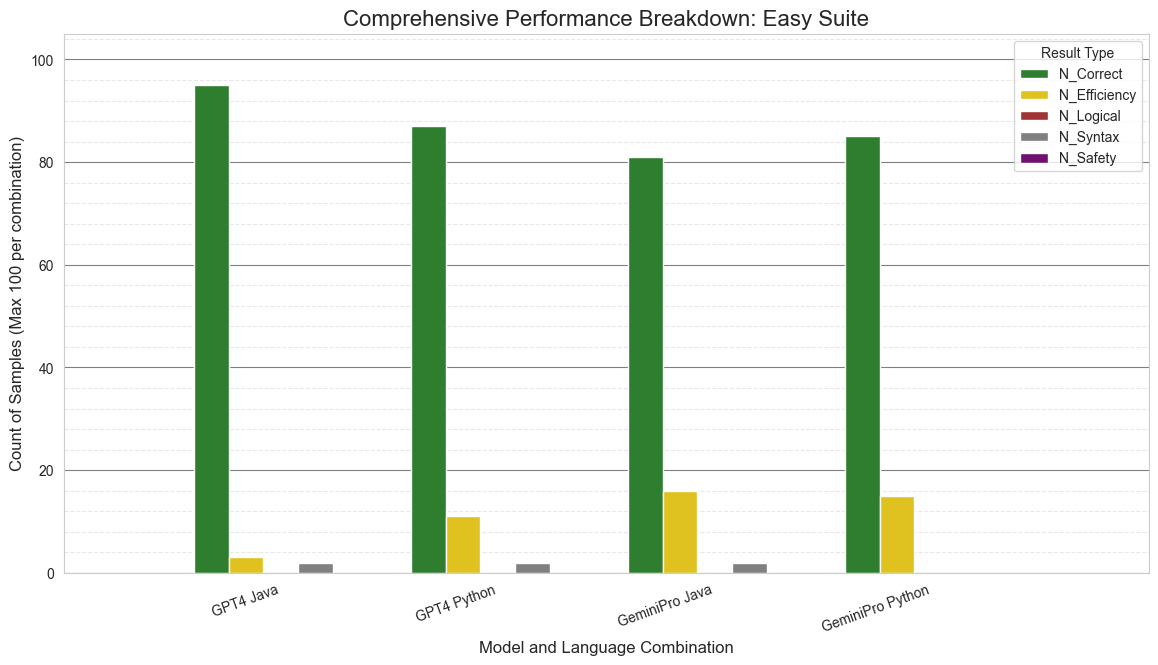

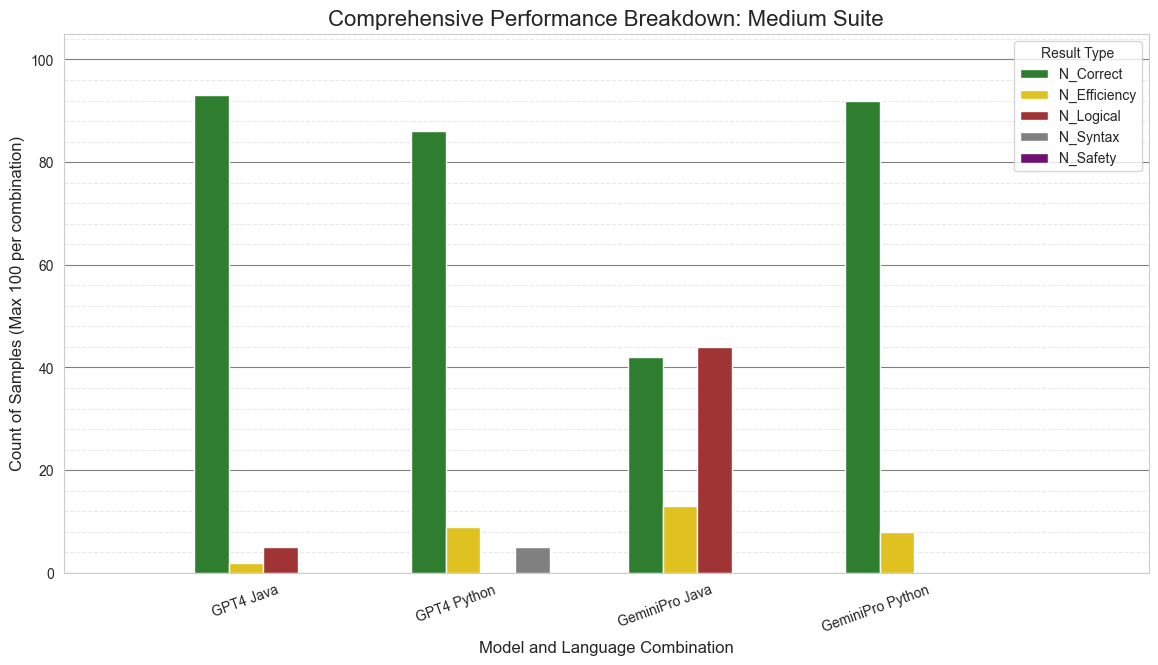

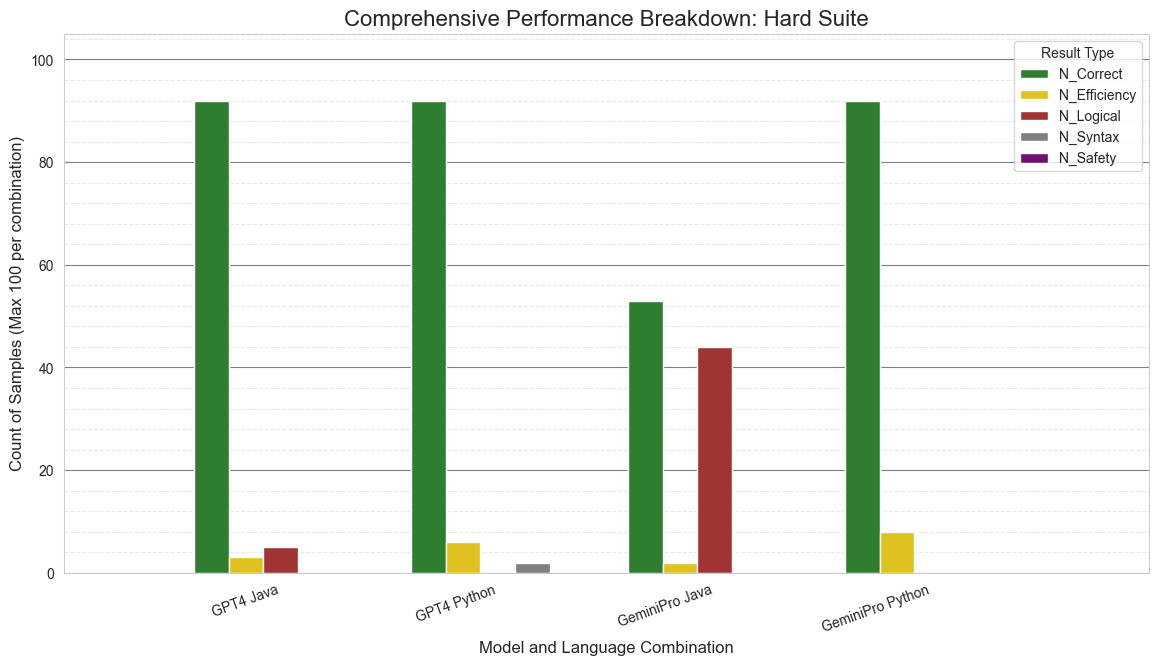

In [ ]:
generate_visualizations(df_combined)